## The value the model seeks to predict is the `mvp_share` column, which represents the result of the MVP voting for each season.

### mvp_share $= \frac{PtsWon}{PtsMax}$

In [1]:
import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')
from helper_functions import print_importances, print_dict_imps, avg_imps, percent_formatter, plot_comparison_for_season

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import joblib
# Load the best model from Models.ipynb
best_model = joblib.load('best_model.pkl')

In [2]:
# Load the data
df_selected = pd.read_csv('df_selected.csv')
features = list(df_selected.columns)
features.append('mvp_share')
features.append('Rank')
df_train = pd.read_csv('df_clean.csv', usecols=features)
labels = df_train.pop("mvp_share")
stratify = df_train.pop("Rank")
del features[10]
del features[10]
features.append('Season')
features.append('name')
df_test = pd.read_csv('df_last.csv', usecols=features)
df_test.rename(columns={'name': 'Name'}, inplace=True)
del features[10]
del features[10]

In [3]:
(X_train, X_test, y_train, y_test) = train_test_split(df_train, 
                                                      labels, 
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=28, 
                                                      stratify=stratify)

# Convert each dataset to array
y_train = y_train.values
y_test = y_test.values
X_train = X_train.values
X_test = X_test.values

#### Use the best model from `Models.ipynb`

In [4]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=28, ...)

In [5]:
# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R-squared:", r2)

Test MSE: 0.0012496458665095921
Test R-squared: 0.7551247765864004


---

## Testing

In [6]:
dfs_n_last = []
for season_n in df_test['Season'].unique():
        df_n = df_test[df_test['Season'] == season_n].copy()
        names_n = df_n["Name"].values
        df_n.drop(['Season', 'Name'], axis="columns", inplace=True)
        feature_n = df_n.to_numpy()

        prediction = best_model.predict(feature_n)
        df_curr = pd.DataFrame(data=feature_n, index=None, columns=features)
        df_curr['Season'] = season_n
        df_curr['name'] = names_n
        df_curr['predicted'] = prediction * 100
        dfs_n_last.append(df_curr)
        df_curr = df_curr.sort_values(by=['predicted'], ascending=False, ignore_index=True)
        
        print(season_n)
        print(df_curr[['name', 'predicted']].head(8))
        print("=============================================================================")
        print("============================================================================\n")
        
df_pred = pd.concat(dfs_n_last, ignore_index=True)

2022
                    name  predicted
0  Giannis Antetokounmpo  36.911350
1           Nikola Jokić  35.449661
2            Joel Embiid  26.598776
3            Luka Dončić  18.806118
4           Jayson Tatum  11.186831
5              Ja Morant  10.647788
6           Jimmy Butler  10.644414
7           Kevin Durant   8.138743

2021
                    name  predicted
0           Nikola Jokić  46.161224
1           James Harden  17.022385
2  Giannis Antetokounmpo  15.917738
3            Joel Embiid  12.433111
4          Stephen Curry  10.667660
5          Kawhi Leonard   9.864919
6           Kyrie Irving   9.609573
7            Luka Dončić   9.521273

2020
                    name  predicted
0           James Harden  39.363899
1  Giannis Antetokounmpo  31.989992
2          Anthony Davis  23.864458
3           LeBron James  18.382017
4          Kawhi Leonard  17.089468
5         Damian Lillard  10.165789
6            Luka Dončić  10.083507
7           Nikola Jokić   4.679622

2019
     

---

# Compare Against True Share

In [7]:
#df_pred = pd.read_csv('predictions.csv')
keep = list(df_pred.columns)
del keep[12]
keep.append('mvp_share')
df_full = pd.read_csv('mvp_data_edit.csv', usecols=keep)
# Merge df_pred with df_full on "name" and "Season" columns
merged_df = pd.merge(df_pred, df_full[['name', 'Season', 'mvp_share']], 
                     on=['name', 'Season'], how='left')
# Rename the 'mvp_share' column to 'actual' in the merged dataframe
merged_df.rename(columns={'mvp_share': 'actual'}, inplace=True)
merged_df['actual'] *= 100

In [8]:
# Define custom colors for 'predicted' and 'actual'
custom_palette = {'predicted': '#E57200', 'actual': '#232D4B'}

In [9]:
# Iterate over unique values in the 'Season' column and create separate plots for each
unique_seasons = merged_df['Season'].unique()

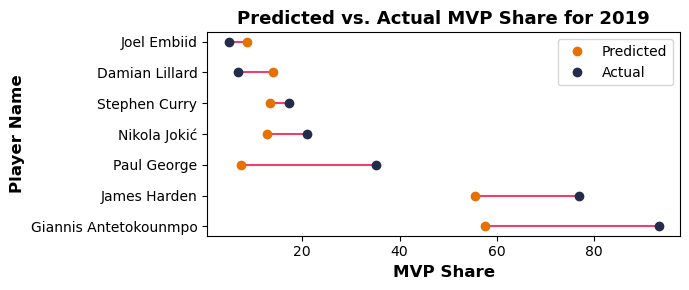

In [10]:
plot_comparison_for_season(merged_df, 2019)

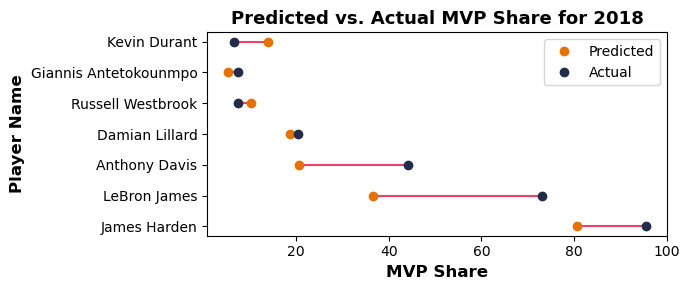

In [11]:
plot_comparison_for_season(merged_df, 2018)

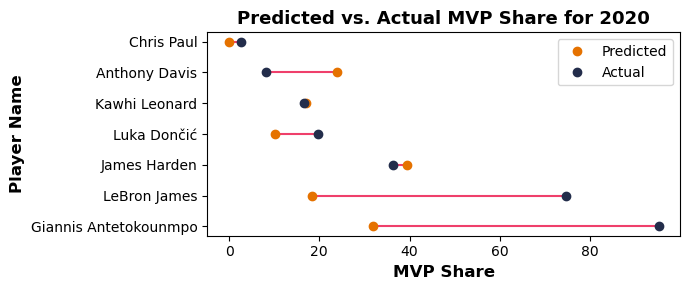

In [12]:
plot_comparison_for_season(merged_df, 2020)

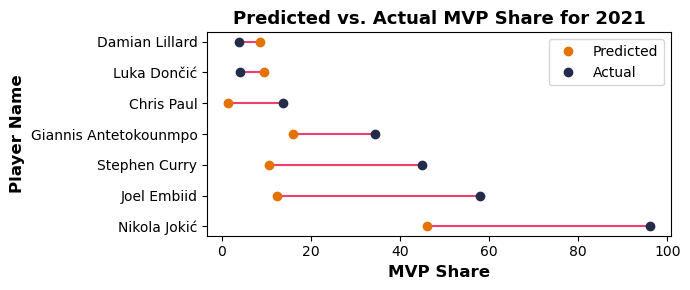

In [13]:
plot_comparison_for_season(merged_df, 2021)

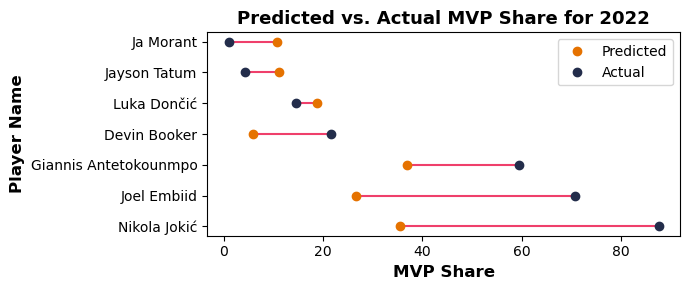

In [14]:
plot_comparison_for_season(merged_df, 2022)

In [15]:
df_results = pd.read_csv('mvp_data_edit.csv')
# Drop Wins and Conference because we combined in cleaning notebook
df_results.drop(columns=['conference', 'W'], inplace=True)
# Filter to seasons after 1980 as we do in training
df_results = df_results[df_results['Season'] >= 1980]
# Pull out the feature importances
feature_importances = best_model.feature_importances_
# Normalize feature importances
normalized_importances = feature_importances / np.sum(feature_importances)
# Construct index
index_values = np.dot(df_results[features].values, normalized_importances)
# Add index values as a new column to the DataFrame
df_results['index'] = index_values
# Rank the 'Index' column within each season group and store the result in a new column 'Ranked_Index'
df_results['Ranked_Index'] = df_results.groupby('Season')['index'].rank(ascending=False)

In [16]:
df_results.to_csv('results.csv', index=False)